### Initialization

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
import pandas as pd
import numpy as np
import pygwalker as pyg
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

### data loading

In [ ]:
# looking into the total amount of images to start

labels = pd.read_csv('C:/Users/gsrav/Documents/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='C:/Users/gsrav/Documents/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

## EDA

### Images

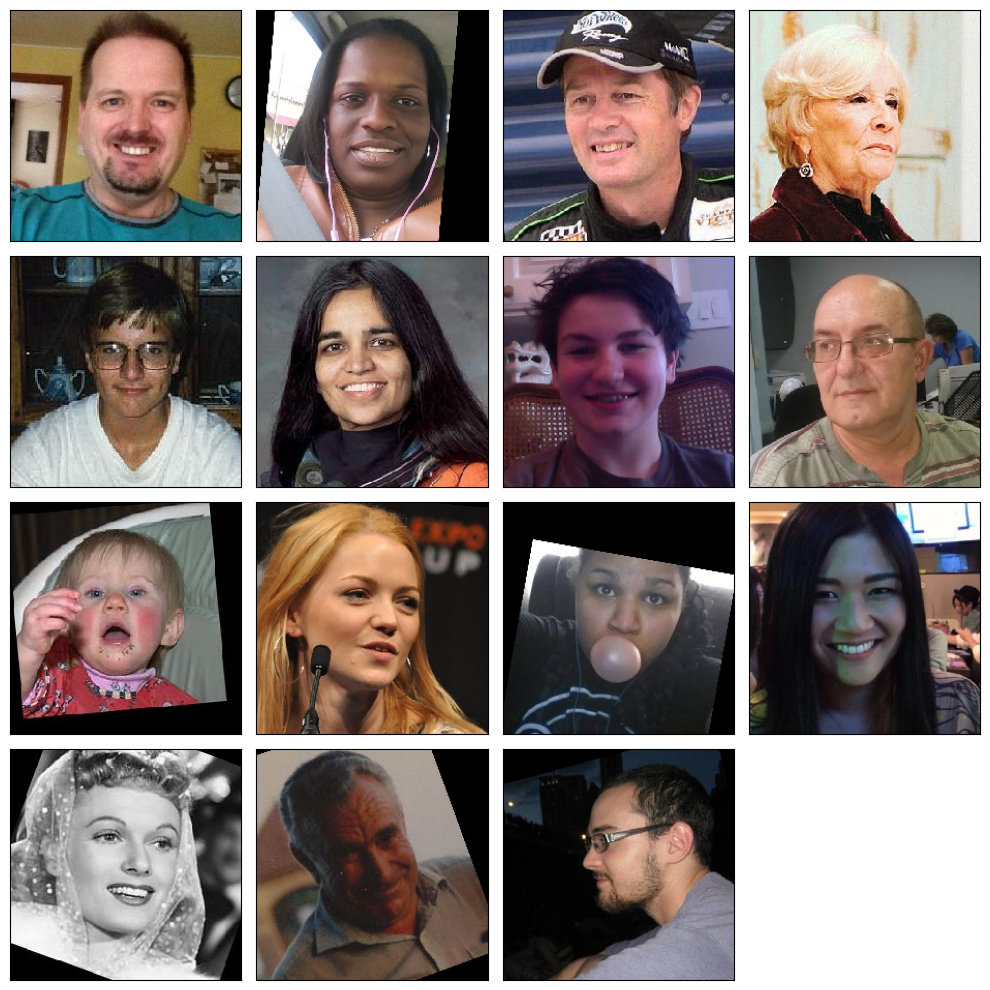

In [5]:
features, target = next(gen_flow)

# display 15 images
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Labels

In [6]:
display(labels)

file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]

In [7]:
label_mix = labels.copy()
underage_target = label_mix[label_mix['real_age'] < 21]['file_name'].count()
overage_target = label_mix[label_mix['real_age'] >= 21]['file_name'].count()
print('Underage Customers:', underage_target, '\nCustomers over the Legal Age:', overage_target)

# pyg.walk(labels) # quick underage vs. over the age visualization

Underage Customers: 2054 
Customers over the Legal Age: 5537


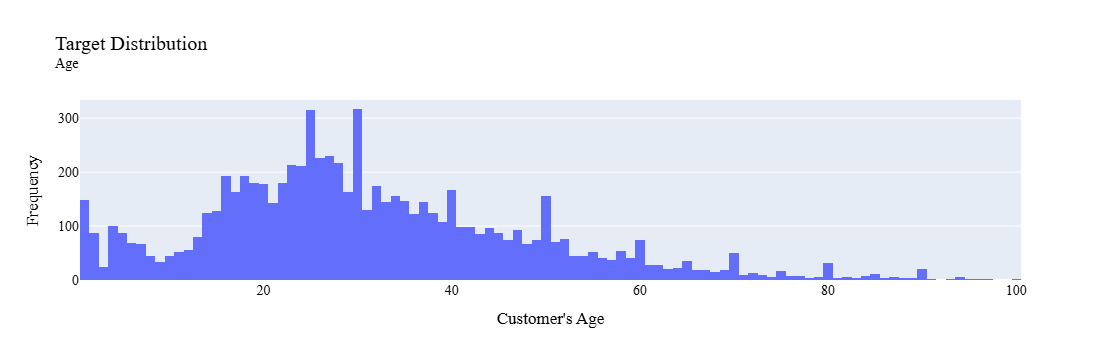

In [8]:
fig = px.histogram(
                  labels['real_age'], 
                  title="Target Distribution<br><sup>Age</sup>",
                  labels={
                     "value": "Customer's Age",
                 })

fig.update_layout(
    yaxis_title="Frequency",
    showlegend=False,
    #legend_title="Legend",
    font=dict(
        family="Avenir",
        size=14,
        color="Black"
    )
)
fig.show()

In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [10]:
labels.describe()

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

### Findings
#### Images:<br>

From our data exploration, we see possible model training 'impacts' from looking at various image samples, these include:<br>
    - Depth, Angles, Brigthness/Contrast, Saturation/Sharpness, Lighting, Noise (missing backgrounds or tons of objects behind the subject for example)<br>
    - Additonal image variability comes through 1) photo quality (selfie vs. image taken by someone else vs. a photo of a photo), 2) objects on the subject's face (beanies, hats, glasses), and 3) the color quality of the images (greyscale vs. color)<br>

#### Labels:

Looking at the labels/targets, we see data distribution being largely skewed towards a category we will call 'over the legal drinking age' opening the door to possible class imbalances<br>
    - 27% of the dataset is allocated to the 'underage' category<br>
    - Imbalance possibility given 'over the age' magnitude (double) compared to the underage total<br>
    - No perceived missing values or NaNs (data contained at a range of ages 1-100)<br>

## Data Modeling

In [11]:
from tensorflow.keras.layers import Dropout, Flatten

In [12]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(validation_split=0.2,
                                      rescale= 1 / 255,
                                      vertical_flip=True,
                                      horizontal_flip=True,
                                      rotation_range=20,
                                      width_shift_range=0.2,
                                      zoom_range=0.2,
                                      height_shift_range=0.2)

    train_datagen_flow = train_datagen.flow_from_dataframe( # automatically search for the image in directory
        dataframe=labels,
        directory='/datasets/faces/final_files/', # path
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw', # raw target values for regression task
        subset='training',
        seed=12345)

    return train_datagen_flow

In [13]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen = ImageDataGenerator(validation_split=0.2,
                                      rescale= 1 / 255)

    test_datagen_flow = test_datagen.flow_from_dataframe( # automatically search for the image in directory
        dataframe=labels,
        directory='/datasets/faces/final_files/', # path
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw', # raw target values for regression task
        subset='validation',
        seed=12345)

    return test_datagen_flow

In [14]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, 
                  loss='mse',
                  metrics=['mae'])

    return model

In [15]:
def train_model(model, 
                train_data, 
                test_data,
                batch_size=None, 
                epochs=20,
                steps_per_epoch=None, 
                validation_steps=None):
    

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Prepare the Script to Run on the GPU Platform

In [16]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### OUTPUT 
    Epoch 1/20 <br>
        356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
    Epoch 2/20 <br>
        356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
    Epoch 3/20 <br>
        356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
    Epoch 4/20 <br>
        356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
    Epoch 5/20 <br>
        356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
    Epoch 6/20 <br>
        356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
    Epoch 7/20 <br>
        356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
    Epoch 8/20 <br>
        356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
    Epoch 9/20 <br>
        356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
    Epoch 10/20 <br>
        356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
    Epoch 11/20 <br>
        356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
    Epoch 12/20 <br>
        356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
    Epoch 13/20 <br>
        356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
    Epoch 14/20 <br>
        356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
    Epoch 15/20 <br>
        356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
    Epoch 16/20 <br>
        356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
    Epoch 17/20 <br>
        356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
    Epoch 18/20 <br>
        356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
    Epoch 19/20 <br>
        356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
    Epoch 20/20 <br>
        356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

### Conclusions
#### Age Prediction for Alcoholic Sales:

    After leveraging the ResNet50 architecture to analyze customer images and choosing optimal parameters, we are able to get to the target MAE of less than 8.        
        With that said, while computer vision may be able to help the customer in this case, given the heightened risk and sensitivity of selling alcohol to people under the legal age along with the significant fines and problems that come with that, it would be highly advisable to incorporate another layer of verification at the very least if this is to be deployed (along with more in-depth tuning/optimization). Good Seed will have to weight the pros and cons of having such system in place and truly relying on it. Will Good Seed be comfortable not having a truly accurate system? predicting someone's age at 20 vs 21 can make a whole world of difference in this scenario...not much room for error here...There is a reason afterall that we don't see this at Whole Foods or other, much larger 'supermarkets'.

#### Other Practical Usage:

    Aside from the possibility of leveraging our computer vision model to predict a person's age when it comes to selling alcohol (assuming this is a U.S. based chain so legal age = 21) Good Seed should be able to leverage our computer vision model to:

        1. categorize fruits and vegetables that are usually weighted and looked up by consumers,

        2. keep track of / monitor items that might not have been scanned (either categorized as losses or theft, up to the business on how to pivot),

        3. potentially track facial movement to predict emotions / emotional state and comparing that data to checkout carts (could open up a new path to advertise food pairings to individual and recurring shoppers) <-- would be extra interesting comparing this information to the time of day / month / year and weather to paint a truly personalized picture per shopper.

    These other usage options may be more beneficial given they don't come with legal difficulties and there is slightly more room for error. A banana is usually going to look like a banana, it won't suddenly appear with aviator sunglasses and a beanie.